## Capstone Project - The Battle of the Neighborhoods (New York) (Week 2)

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this Capstone project I am trying to figure out the most popular venue in New York city and to find out the optimal location/neighborhood that is not already crowded with that popular venue. I am also trying to analyse the venue in each Borough in New York city. Specifically, this report will be targeted to stakeholders interested in looking most popular venue in New York city and to find appropriate location that is not already crowded.

Since there are lots of variety of venues in New York, we will try to detect **Most popular venue and location that are not already crowded with that venue**. We would also prefer locations **as close to city as possible that covers most nearby neighborhoods**, assuming that first two conditions are met.

## Data <a name="data"></a>

As per my problem description, below mentioned factors will influence my decision:
* Variety of venues in the neighborhood.
* Number of different venue type in each Borough.
* Number of neighborhoods in each Borough that is not already crowded with most popular venue.
* Location of each uncrowded neighborhood to cluster them and find out highly dense cluster.

I will be using the following data sources to extract the required information:
* Raw data for New York city will be downloaded from external source.
* Bourough, neighborhood and their latitude and longitude data will be extracted from downloaded data.
* Number of venues, venue category and corresponding latitude and longitude of each venue in every neighborhood will be obtained using **Foursquare API**.

So by using these information we will try to find out most common venue and optimal location for such venue. These neighborhood data will be clustered by using ***K-mean Clustering*** method to identify optimal group of neighborhoods which are not already crowded with most common venue. 

Before extracting data and transforming them into appropriate format let's import required library:

In [1]:
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim       # convert an address into latitude and longitude values
import json                                 # library to handle JSON files
import requests                             # library to handle requests


import matplotlib.cm as cm                  # Matplotlib and associated plotting modules
import matplotlib.colors as colors

from sklearn.cluster import KMeans          # import k-means from clustering stage

import folium                               # map rendering library

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Libraries imported.


Let's first find the latitude & longitude of the New York City, using geopy's geocoders module.

In [2]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_latitude = location.latitude
ny_longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Download and Exploring Dataset

The dataset is available on cloud to download directly. That dataset can also be downloaded from link: https://geo.nyu.edu/catalog/nyu_2451_34572

In [3]:
!wget -q -O newyork_data.json https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


### Load and explore the data

The data is already downloaded. Next, let's load the data.

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

If we look at the data we find that all the relevant data is in the ***features*** key, which is a list of the neighborhoods. So, here I am creating a new variable that stores this extracted data.

In [5]:
neighborhoods_data = newyork_data['features']

Let's have a look at the first item in this list.

In [6]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Tranform data into dataframe

The above data is a nested dictionary. Let's transform dictionary into pandas' dataframe. So first let's create an empty dataframe with required column names.

In [7]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [9]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly have a look at the resulting dataframe:

In [10]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Examine the number of borough and neighborhood:

In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Number of rows in the resulting dataframe:

In [12]:
len(neighborhoods.groupby(['Borough','Neighborhood']))

306

### Create a map of New York with each Borough & neighborhoods

Finding latitude & longitude of each borough:

In [14]:
latitude = []
longitude = []

geolocator = Nominatim(user_agent="ny_explorer")

for br in neighborhoods['Borough'].unique():
    location = geolocator.geocode(br)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

In [15]:
colour = {'Bronx':'orange', 'Brooklyn':'darkred', 'Manhattan':'green', 'Queens':'blue', 'Staten Island':'gray'}

borough = neighborhoods['Borough'].unique()

map_newyork = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

for lat, lon, br in zip(latitude, longitude, borough):
    folium.Marker(
        location=[lat, lon],
        popup=br,
        icon=folium.Icon(color = colour[br])
    ).add_to(map_newyork)
    
    
# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colour[borough],
        fill=True,
        fill_color=colour[borough],
        fill_opacity=0.4,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Exploring neighborhood by using Foursquare API

##### Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'YQ2PMOH5JBAXNLXZXID4U2N5WXMXXPFWAKSR231LXML2G0EI' # your Foursquare ID
CLIENT_SECRET = 'NBLCRJTGZHAJOAAETKETGWFHZEMIP5AJRRIQR1GCALMLFW5U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YQ2PMOH5JBAXNLXZXID4U2N5WXMXXPFWAKSR231LXML2G0EI
CLIENT_SECRET:NBLCRJTGZHAJOAAETKETGWFHZEMIP5AJRRIQR1GCALMLFW5U


#### Create a function to expolre all neighborhoods in New York

Here our target is to find upto 100 venues in each neighborhood.

In [17]:
LIMIT = 100
def getNearbyVenues(borough, names, latitudes, longitudes, radius=500):
    
    count = 1
    venues_list=[]
    for borough, name, lat, lng in zip(borough, names, latitudes, longitudes):
        print('{}: {}'.format(count, name))
        count += 1    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                             'Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

Calling above function to find venues in each neighborhood but I have already executed the function so here just commenting it:

In [ ]:
'''
ny_venues = getNearbyVenues(borough=neighborhoods['Borough'],
                                   names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
'''

Let's save ny_venues in a csv file and I have saved it:

In [23]:
#ny_venues.to_csv('ny_venues.csv', index=False)

Reading saved csv file to transform data in appropriate format:

In [24]:
ny_venues = pd.read_csv('ny_venues.csv')

In [25]:
ny_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### Check the size of the resulting dataframe

Let's check how many venues were returned for each neighborhood:

In [26]:
#ny_venues.groupby('Neighborhood')['Venue'].count()

Let's find out how many unique categories can be curated from all the returned venues:

In [27]:
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

There are 427 uniques categories.


## Methodology <a name="methodology"></a>

In this capston project my main objective is to explore each borough and find out the **most popular venue** and then figure out the **optimal location** which is not crowded with that popular venue and cluster the neighborhoods to identify highly dense cluster of neighborhood which have not already crowded.

In first step I have collected the required data from external source and then explored each neighborhood by using Foursquare API to find venues in each neighborhood.

Second step in our analysis will be to find the top 5 most common venues in each borough.

In third and final step I will filter the original data with neighborhoods which has no top most common venue. Then visualize each neighborhood. My main focus is to find out most promising area/zone that meet some basic requirements established in discussion with stakeholders. I will prompt map of all such locations and also create clusters (using **k-means clustering**) of those locations to identify highly dense neighborhoods which would be target for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's first transform the data by using one hot encoding method on **'Venue Category'** column.

In [28]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough & neighborhood column back to dataframe
ny_onehot = pd.concat([ny_venues['Borough'], ny_venues['Neighborhood'], ny_onehot], axis=1)


In [29]:
ny_onehot.head()

,Borough,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera

And let's examine the new dataframe size.

In [30]:
ny_onehot.shape

(10265, 429)

Next, let's group rows by borough and by taking the sum of occurrence of each category

In [31]:
ny_grouped = ny_onehot.groupby('Borough').sum().reset_index()

In [32]:
ny_grouped.head()

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optica

Let's again confirm the new size:

In [33]:
ny_grouped.shape

(5, 428)

Filter the duplicate columns from dataset.

In [34]:
ny_onehot = ny_onehot.loc[:, ~ny_onehot.columns.duplicated()]

In [35]:
ny_onehot.shape

(10265, 428)

Again grouping the encoded dataset by borough & neighborhood combined and sum the occurance of each venue.

In [36]:
ny_grouped1 = ny_onehot.groupby(['Borough', 'Neighborhood']).sum().reset_index()

In [37]:
ny_grouped1.head()

,Borough,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optica

In [38]:
ny_grouped1.shape

(305, 428)

#### Let's print each borough along with the top 5 most common venues

In [39]:
for i in ny_grouped.index:
    print("----" + ny_grouped.iloc[i, 0] + "----")
    print('Venue' + '\t\t' + 'Frequency')
    print(ny_grouped.iloc[i, 1:].sort_values(ascending=False).head(5))
    print('\n')

----Bronx----
Venue		Frequency
Pizza Place      105
Deli / Bodega     47
Donut Shop        46
Pharmacy          41
Supermarket       40
Name: 0, dtype: object


----Brooklyn----
Venue		Frequency
Pizza Place      131
Coffee Shop       91
Bar               87
Bakery            66
Deli / Bodega     65
Name: 1, dtype: object


----Manhattan----
Venue		Frequency
Coffee Shop            135
Italian Restaurant     123
American Restaurant     82
Café                    79
Pizza Place             75
Name: 2, dtype: object


----Queens----
Venue		Frequency
Pizza Place           88
Deli / Bodega         79
Chinese Restaurant    64
Bakery                56
Donut Shop            55
Name: 3, dtype: object


----Staten Island----
Venue		Frequency
Bus Stop              47
Pizza Place           45
Italian Restaurant    42
Deli / Bodega         36
Bagel Shop            23
Name: 4, dtype: object




Here we can see that each borough is mostly crowded with **Pizza Place** and it is the most popular venue.

#### Let's put that into a dataframe

First, let's write a function to sort the venues in descending order.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now create new dataframe and display the top 5 venues for each Borough.

In [41]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = ny_grouped['Borough']

for ind in np.arange(ny_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Pizza Place,Deli / Bodega,Donut Shop,Pharmacy,Supermarket
1,Brooklyn,Pizza Place,Coffee Shop,Bar,Bakery,Deli / Bodega
2,Manhattan,Coffee Shop,Italian Restaurant,American Restaurant,Café,Pizza Place
3,Queens,Pizza Place,Deli / Bodega,Chinese Restaurant,Bakery,Donut Shop
4,Staten Island,Bus Stop,Pizza Place,Italian Restaurant,Deli / Bodega,Bagel Shop


Extract data with required columns:

In [42]:
new_york = ny_grouped1[['Borough', 'Neighborhood', 'Pizza Place']]

In [43]:
new_york.shape

(305, 3)

In [44]:
new_york.head()

,Borough,Neighborhood,Pizza Place
0,Bronx,Allerton,5
1,Bronx,Baychester,1
2,Bronx,Bedford Park,3
3,Bronx,Belmont,8
4,Bronx,Bronxdale,1


Some of the neighborhoods has Pizza place and some of them don't. So transforming Pizza Place column into binary value where 1 represents neighborhood having Pizza Place and 0 represents absence of Pizza Place. 

In [46]:
for i in new_york.index:
    if new_york.loc[i, 'Pizza Place'] > 0:
        new_york.loc[i, 'Pizza Place'] = 1

In [47]:
new_york.head()

,Borough,Neighborhood,Pizza Place
0,Bronx,Allerton,1
1,Bronx,Baychester,1
2,Bronx,Bedford Park,1
3,Bronx,Belmont,1
4,Bronx,Bronxdale,1


In [48]:
new_york.tail()

,Borough,Neighborhood,Pizza Place
300,Staten Island,Travis,1
301,Staten Island,West Brighton,1
302,Staten Island,Westerleigh,0
303,Staten Island,Willowbrook,1
304,Staten Island,Woodrow,1


In [49]:
ny_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Bronx,Wakefield,40.894705,-73.847201,Walgreens,40.896687,-73.844850,Pharmacy
4,Bronx,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Here I am selecting location data as well for each neighborhood so that I can visualize them and save them into a new variable.

In [50]:
temp = ny_venues[['Borough', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']]

Droping duplicate rows because our concern is to find the location data of each unique neighborhood.

In [51]:
temp = temp.drop_duplicates().reset_index(drop=True)

In [52]:
temp.shape

(305, 4)

In [53]:
temp.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Next, let's sort the borough & neighborhood columns combined so that we can append Pizza Place column from new_york data in the exact sequence.  

In [54]:
temp = temp.sort_values(['Borough', 'Neighborhood']).reset_index(drop=True)

In [55]:
temp.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Bronx,Allerton,40.865788,-73.859319
1,Bronx,Baychester,40.866858,-73.835798
2,Bronx,Bedford Park,40.870185,-73.885512
3,Bronx,Belmont,40.857277,-73.888452
4,Bronx,Bronxdale,40.852723,-73.861726


In [56]:
temp.tail()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
300,Staten Island,Travis,40.586314,-74.190737
301,Staten Island,West Brighton,40.631879,-74.107182
302,Staten Island,Westerleigh,40.621090,-74.133041
303,Staten Island,Willowbrook,40.603707,-74.132084
304,Staten Island,Woodrow,40.541968,-74.205246


Now appending Pizza Place column from new_york data so that we can filter neighborhood in each borough which has no Pizza Place vanue and cluster them.

In [57]:
temp['Pizza Place'] = new_york['Pizza Place']

In [58]:
temp.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place
0,Bronx,Allerton,40.865788,-73.859319,1
1,Bronx,Baychester,40.866858,-73.835798,1
2,Bronx,Bedford Park,40.870185,-73.885512,1
3,Bronx,Belmont,40.857277,-73.888452,1
4,Bronx,Bronxdale,40.852723,-73.861726,1


In [59]:
temp.tail()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place
300,Staten Island,Travis,40.586314,-74.190737,1
301,Staten Island,West Brighton,40.631879,-74.107182,1
302,Staten Island,Westerleigh,40.621090,-74.133041,0
303,Staten Island,Willowbrook,40.603707,-74.132084,1
304,Staten Island,Woodrow,40.541968,-74.205246,1


### Cluster Analysis for Bronx

In [60]:
bronx = temp[temp['Borough'] == 'Bronx']
bronx.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place
0,Bronx,Allerton,40.865788,-73.859319,1
1,Bronx,Baychester,40.866858,-73.835798,1
2,Bronx,Bedford Park,40.870185,-73.885512,1
3,Bronx,Belmont,40.857277,-73.888452,1
4,Bronx,Bronxdale,40.852723,-73.861726,1


In [61]:
bronx.shape

(52, 5)

In [62]:
bronx['Pizza Place'].value_counts()

1    40
0    12
Name: Pizza Place, dtype: int64

Now selecting neighborhood which does not has Pizza Place venue. 

In [63]:
bronx = bronx[bronx['Pizza Place'] == 0]
bronx.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place
8,Bronx,Clason Point,40.806551,-73.854144,0
12,Bronx,Country Club,40.844246,-73.824099,0
15,Bronx,Edenwald,40.884561,-73.848083,0
17,Bronx,Fieldston,40.895437,-73.905643,0
23,Bronx,Longwood,40.815099,-73.895788,0


Run *k*-means to cluster the neighborhood.

In [64]:
# set number of clusters
kclusters = 11

# store error for each value of cluser number
wcss = []

# run k-means clustering to cluster neighborhood based on geographical location
for k in range(1, kclusters):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(bronx[['Neighborhood Latitude', 'Neighborhood Longitude']])
    wcss.append(kmeans.inertia_)

Graphically showing the elbow method to find the optimal number of clusters.

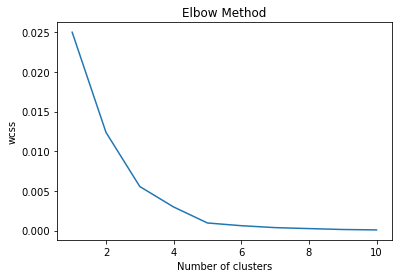

In [65]:
import matplotlib.pyplot as plt
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

Here we can see that at 5 number of cluster error is low and after that error is not decreasing significantly.

In [66]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(bronx[['Neighborhood Latitude', 'Neighborhood Longitude']])

In [67]:
kmeans.labels_[0:10]

array([2, 4, 1, 0, 3, 1, 4, 3, 0, 2])

Let's create a new dataframe that includes the cluster label for each neighborhood.

In [68]:
# add clustering labels
bronx.insert(5, 'Cluster Labels', kmeans.labels_)
bronx.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels
8,Bronx,Clason Point,40.806551,-73.854144,0,2
12,Bronx,Country Club,40.844246,-73.824099,0,4
15,Bronx,Edenwald,40.884561,-73.848083,0,1
17,Bronx,Fieldston,40.895437,-73.905643,0,0
23,Bronx,Longwood,40.815099,-73.895788,0,3


Finally, let's visualize the resulting clusters

In [69]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx['Neighborhood Latitude'], bronx['Neighborhood Longitude'], bronx['Neighborhood'], bronx['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Analysis for Brooklyn

In [70]:
brooklyn = temp[temp['Borough'] == 'Brooklyn']
brooklyn['Pizza Place'].value_counts()

1    54
0    16
Name: Pizza Place, dtype: int64

In [71]:
brooklyn = brooklyn[brooklyn['Pizza Place'] == 0]

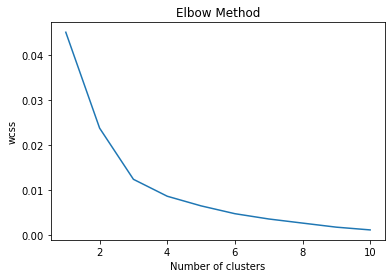

In [72]:
# set number of clusters
kclusters = 11
wcss = []

# run k-means clustering
for k in range(1, kclusters):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(brooklyn[['Neighborhood Latitude', 'Neighborhood Longitude']])
    wcss.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()



In [73]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(brooklyn[['Neighborhood Latitude', 'Neighborhood Longitude']])
kmeans.labels_[0:10]

array([0, 2, 3, 0, 2, 0, 3, 0, 0, 0])

In [74]:
# add clustering labels
brooklyn.insert(5, 'Cluster Labels', kmeans.labels_)
brooklyn.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels
56,Brooklyn,Bergen Beach,40.615150,-73.898556,0,0
59,Brooklyn,Brighton Beach,40.576825,-73.965094,0,2
60,Brooklyn,Broadway Junction,40.677861,-73.903317,0,3
64,Brooklyn,Canarsie,40.635564,-73.902093,0,0
75,Brooklyn,Dyker Heights,40.619219,-74.019314,0,2


In [75]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn['Neighborhood Latitude'], brooklyn['Neighborhood Longitude'], brooklyn['Neighborhood'], brooklyn['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Analysis for Manhattan

In [76]:
manhattan = temp[temp['Borough'] == 'Manhattan']
manhattan['Pizza Place'].value_counts()

1    33
0     7
Name: Pizza Place, dtype: int64

In [77]:
manhattan = manhattan[manhattan['Pizza Place'] == 0]

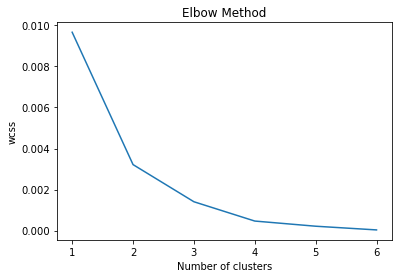

In [78]:
# set number of clusters 7 as there are only 7 neighborhood without Pizza Place
kclusters = 7
wcss = []

# run k-means clustering
for k in range(1, kclusters):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(manhattan[['Neighborhood Latitude', 'Neighborhood Longitude']])
    wcss.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(range(1,7), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [79]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(manhattan[['Neighborhood Latitude', 'Neighborhood Longitude']])
kmeans.labels_[0:10]

array([1, 1, 0, 0, 2, 1, 1])

In [80]:
# add clustering labels
manhattan.insert(5, 'Cluster Labels', kmeans.labels_)
manhattan.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels
127,Manhattan,Civic Center,40.715229,-74.005415,0,1
132,Manhattan,Flatiron,40.739673,-73.990947,0,1
136,Manhattan,Hudson Yards,40.756658,-74.000111,0,0
139,Manhattan,Lincoln Square,40.773529,-73.985338,0,0
143,Manhattan,Manhattanville,40.816934,-73.957385,0,2


In [81]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan['Neighborhood Latitude'], manhattan['Neighborhood Longitude'], manhattan['Neighborhood'], manhattan['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Analysis for Queens

In [82]:
queens = temp[temp['Borough'] == 'Queens']
queens['Pizza Place'].value_counts()

1    48
0    33
Name: Pizza Place, dtype: int64

In [83]:
queens = queens[queens['Pizza Place'] == 0]

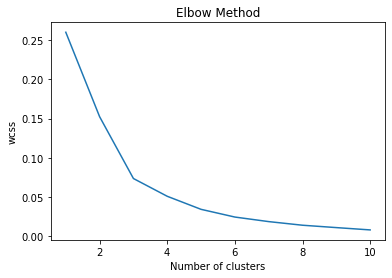

In [84]:
# set number of clusters
kclusters = 11
wcss = []

# run k-means clustering
for k in range(1, kclusters):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(queens[['Neighborhood Latitude', 'Neighborhood Longitude']])
    wcss.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [85]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(queens[['Neighborhood Latitude', 'Neighborhood Longitude']])
kmeans.labels_[0:10]

array([3, 1, 1, 0, 2, 0, 3, 1, 1, 3])

In [86]:
# add clustering labels
queens.insert(5, 'Cluster Labels', kmeans.labels_)
queens.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels
165,Queens,Auburndale,40.761730,-73.791762,0,3
168,Queens,Bayswater,40.611322,-73.765968,0,1
170,Queens,Bellaire,40.733014,-73.738892,0,1
171,Queens,Belle Harbor,40.576156,-73.854018,0,0
173,Queens,Blissville,40.737251,-73.932442,0,2


In [87]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens['Neighborhood Latitude'], queens['Neighborhood Longitude'], queens['Neighborhood'], queens['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster Analysis for Staten Island

In [88]:
staten_island = temp[temp['Borough'] == 'Staten Island']
staten_island['Pizza Place'].value_counts()

0    33
1    29
Name: Pizza Place, dtype: int64

In [89]:
staten_island = staten_island[staten_island['Pizza Place'] == 0]

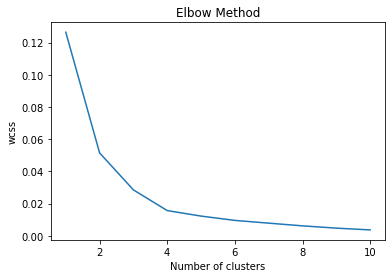

In [90]:
# set number of clusters
kclusters = 11
wcss = []

# run k-means clustering
for k in range(1, kclusters):
    kmeans = KMeans(n_clusters = k, random_state=0).fit(staten_island[['Neighborhood Latitude', 'Neighborhood Longitude']])
    wcss.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

In [91]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(staten_island[['Neighborhood Latitude', 'Neighborhood Longitude']])
kmeans.labels_[0:10]

array([2, 0, 2, 1, 2, 3, 0, 3, 3, 2])

In [92]:
# add clustering labels
staten_island.insert(5, 'Cluster Labels', kmeans.labels_)
staten_island.head() # check the last columns!

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels
245,Staten Island,Arlington,40.635325,-74.165104,0,2
247,Staten Island,Bay Terrace,40.553988,-74.139166,0,0
248,Staten Island,Bloomfield,40.605779,-74.187256,0,2
250,Staten Island,Butler Manor,40.506082,-74.229504,0,1
253,Staten Island,Chelsea,40.594726,-74.189560,0,2


In [94]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(staten_island['Neighborhood Latitude'], staten_island['Neighborhood Longitude'], staten_island['Neighborhood'], staten_island['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In the above visual representation we can see that **Queens and Staten Island** both are not much crowded with pizza place. In Queens' **cluster 1** consists majority of neighborhoods so it can be considered for optimal location. Similarily in Staten Island we can see that all clusters are highly dense and **cluster 3** is more appropriate cluster to be considered for optimal location.

Let's see which cluster is optimal for consideration by adding neighborhoods having pizza place in Queens and Staten Island.

In [95]:
queens1 = temp[temp['Borough'] == 'Queens']
queens1 = queens1[queens1['Pizza Place'] == 1]

map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(queens1['Neighborhood Latitude'], queens1['Neighborhood Longitude'], queens1['Neighborhood']):
    label = folium.Popup(str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    
for lat, lon, poi, cluster in zip(queens['Neighborhood Latitude'], queens['Neighborhood Longitude'], queens['Neighborhood'], queens['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [96]:
staten_island1 = temp[temp['Borough'] == 'Staten Island']
staten_island1 = staten_island1[staten_island1['Pizza Place'] == 1]

map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(staten_island['Neighborhood Latitude'], staten_island['Neighborhood Longitude'], staten_island['Neighborhood'], staten_island['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
for lat, lon, poi in zip(staten_island1['Neighborhood Latitude'], staten_island1['Neighborhood Longitude'], staten_island1['Neighborhood']):
    label = folium.Popup(str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Here we added neighborhood with pizza place and we can clearly see that in Staten Island all clusters are more closely surrounded by pizza place. While in Queens' cluster 1 is not as much crowded with pizza place. So we can select **Queens' cluster 1** for optimal location.

In [97]:
q = queens[queens['Cluster Labels'] == 1]
q

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels
168,Queens,Bayswater,40.611322,-73.765968,0,1
170,Queens,Bellaire,40.733014,-73.738892,0,1
177,Queens,Brookville,40.660003,-73.751753,0,1
178,Queens,Cambria Heights,40.692775,-73.735269,0,1
195,Queens,Hollis,40.711243,-73.759250,0,1
196,Queens,Holliswood,40.720957,-73.767142,0,1
205,Queens,Laurelton,40.667884,-73.740256,0,1
219,Queens,Queens Village,40.718893,-73.738715,0,1
226,Queens,Rochdale,40.675211,-73.772588,0,1
229,Queens,Rosedale,40.659816,-73.735261,0,1


Now let's calculate the center of this cluster which is the mean of latitude & longitude of each neighborhoods seperately. 

In [98]:
c_lat = q['Neighborhood Latitude'].mean()
c_lon = q['Neighborhood Longitude'].mean()

In [99]:
c_lat

40.68408969805656

In [100]:
c_lon

-73.75889149189973

Here again visualizing the center in that cluster:

In [101]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens['Neighborhood Latitude'], queens['Neighborhood Longitude'], queens['Neighborhood'], queens['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
folium.Marker(
        location=[c_lat, c_lon],
        popup='Center',
        icon=folium.Icon(color = 'green')
    ).add_to(map_clusters)
map_clusters

The next step is to calculate the distance of each neighborhood from center so that we can find the closest neighborhood from center.

In [102]:
from geopy.distance import geodesic
center = (c_lat, c_lon)
dist = []

for lat, lon in zip(q['Neighborhood Latitude'], q['Neighborhood Longitude']):
    dist.append(geodesic(center, (lat, lon)).miles)

In [103]:
dist

[5.034854088936308,
 3.5354531673210667,
 1.703796689007102,
 1.377917867192631,
 1.8737592015094116,
 2.5805649680536895,
 1.486229209424893,
 2.6248645253138876,
 0.9449710035397473,
 2.08485044063367,
 1.877770487359448,
 2.884549247155401,
 1.2349341466858945,
 0.7146524204276774]

Adding distance to the cluster dataframe.

In [106]:
q['Distance'] = dist

<ipython-input-106-d22baa28ceef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q['Distance'] = dist


In [107]:
q = q.reset_index(drop=True)
q

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels,Distance
0,Queens,Bayswater,40.611322,-73.765968,0,1,5.034854
1,Queens,Bellaire,40.733014,-73.738892,0,1,3.535453
2,Queens,Brookville,40.660003,-73.751753,0,1,1.703797
3,Queens,Cambria Heights,40.692775,-73.735269,0,1,1.377918
4,Queens,Hollis,40.711243,-73.759250,0,1,1.873759
5,Queens,Holliswood,40.720957,-73.767142,0,1,2.580565
6,Queens,Laurelton,40.667884,-73.740256,0,1,1.486229
7,Queens,Queens Village,40.718893,-73.738715,0,1,2.624865
8,Queens,Rochdale,40.675211,-73.772588,0,1,0.944971
9,Queens,Rosedale,40.659816,-73.735261,0,1,2.084850


Next step is to sort the dataframe based on distance in increasing order. So we get the first row as shortest disance neighborhood.

In [108]:
point = q.loc[q['Distance'].sort_values().index, :].head(1)
point

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Pizza Place,Cluster Labels,Distance
13,Queens,St. Albans,40.694445,-73.758676,0,1,0.714652


Visualizing that optimal neighbohood again:

In [109]:
# create map
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens['Neighborhood Latitude'], queens['Neighborhood Longitude'], queens['Neighborhood'], queens['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=9,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
folium.Marker(
        location=[point['Neighborhood Latitude'], point['Neighborhood Longitude']],
        popup=point['Neighborhood'].values,
        icon=folium.Icon(color = 'green')
    ).add_to(map_clusters)
map_clusters

## Results and Discussion <a name="results"></a>

As our analysis and graphical visualization shows that there are number of different venues in each borough. But we have seen that each borough has mostly crowded with pizza places. And in each borough there are neighborhoods with pizza palce and non pizza place. Their ratio are mostly fair in each borough but geological location is different. In some borough non pizza places are surrounded with pizza places and in some borough they are isolated. So our attention was focused on such areas which are isolated from pizza places and covers major neighborhood of non pizza places.

Focusing on the objective we first group the data by borough and find out the number of occurance of each venue type. And then sort the venue type by its number of occurance which shows the top most common venue which is pizza place. 

We again sort the data by borough & neighborhood combined to see that which neighborhood has top most venue in each borough. We filter these neighborhood which has no pizza place. 

These location were then clustered to create zones of interest which contain large number of neighborhood not already crowded with pizza place. 

Result of all this shows that there are two clusters which can be considered for optimal location for pizza place. One cluster is from Queens borough and other is from Staten Island. Both clusters fairly contains large number of neighborhoods. But in Staten Island cluster is already surrounded by pizza places which are more close to non pizza places. While in Queens' cluster pizza places are far as compared to Staten Island. So we are considering Queens' cluster to find optimal location. For optimal location we first calculate the center of that cluster and then calculate the distance of each neighborhood in that cluster from center. We sort the distance to find the closest location from center which was **St. Albans** in **Queens borough**. This recommended loction should therefore be considered only as a starting point. There may be other factors taken into account and other conditions may be introduced for optimal location.

## Conclusion <a name="conclusion"></a>

Purpose of this capston project was to identify an optimal location that is not crowded by most common venue in New York city. It gives stakeholders as a starting point for consideration. We calculated the number of occurance of each venues in each borough which gives an idea about most common or popular venue in each borough. We found that pizza place is most common among all borough. Then clustering of those neighborhoods where there were no pizza place gave us a zone of interest that meet some basic conditions. 

We considered the cluster of neighborhoods which was not already crowded/surrounded by pizza places. 

Final decision on optimal location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended cluster of enighborhood, taking other factors and conditions into consideration.